In [224]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

# these are new 
import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import shutil                   # file management tools 
import os                       # operating system tools (check files)

import geopandas as gpd # this is the main geopandas 
from shapely.geometry import Point, Polygon # also needed

import pyarrow as pa
import pyarrow.parquet as pq

##########################
# Then this stuff below allows us to make a nice inset


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

### Grab data from NYTimes

Thank you for organizing this. It's very simple...

- **To DO** fix the counties around NYC

In [225]:
df = pd.read_csv("https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv")

In [226]:
nyc = df.county == "New York City"
df.loc[nyc,"fips"] = 36061

In [227]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

In [228]:
latest_date = df.date.max()

In [229]:
latest_date = latest_date.strftime("%m/%d/%Y")

In [230]:
df.set_index("date", inplace = True)

In [231]:
dfall = df.loc[latest_date]

**Note** The nytimes dataset reports **cumulative** cases, not number reported each day.

In [232]:
dfall[dfall.county == "New York City"]

,county,state,fips,cases,deaths
date,,,,,
2020-03-26,New York City,New York,36061.0,23112,365


In [233]:
total = dfall.cases.sum()

###  Get Shapefiles

The next couple of cells download the requisite shapefiles from the US census. They are unzipped in a folder called shapefiles and then county. So they are assuming some structure behind your folder setup. 

In [234]:
print("")
print("**********************************************************************************")
print("Downloading Shape files")
print("")

cwd = os.getcwd()

county_url = "https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip"
    
r = requests.get(county_url ) 

county_shapefile = zf.ZipFile(io.BytesIO(r.content)) 

county_shapefile.extractall(path = cwd + "\\shapefiles\\county")

del r, county_shapefile


**********************************************************************************



In [235]:
state_url = "https://www2.census.gov/geo/tiger/TIGER2017/STATE/tl_2017_us_state.zip"
    
r = requests.get(state_url) 

state_shapefile = zf.ZipFile(io.BytesIO(r.content)) 

state_shapefile.extractall(path = cwd + "\\shapefiles\\state")

del r, state_shapefile

In [236]:
cwd = os.getcwd()

county_shape = cwd + "\\shapefiles\\county\\tl_2017_us_county.shx"

us_map = gpd.read_file(county_shape)

us_map = us_map.to_crs({'init': 'epsg:3395'})

In [237]:
us_map["geometry"] = us_map["geometry"].simplify(200)
# This was important. The geometry in the tigerline file si
# too fine, orginal map was 350mb. simply basicly simplifies the geometry,
# making the map take up less memory and load faster. Still not sure
# what the number exactly means.

In [238]:
us_map.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,+41.9158651,-096.7885168,POLYGON ((-10800163.11812986 5132991.983053582...
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-13740876.52543789 5787729.82287615,..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016761648,29147345,+34.3592729,-104.3686961,POLYGON ((-11640388.27442317 4004583.794358812...
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169252486,22867561,+40.7835474,-096.6886584,POLYGON ((-10788038.53315113 4978192.963294434...
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645186,1718484,+40.1764918,-098.0468422,POLYGON ((-10939774.56882773 4851419.990907463...


In [239]:
us_map["area_fips"] = (us_map.STATEFP.astype(str) + us_map.COUNTYFP.astype(str)).astype(int)

###  Merge and Plot

The next couple of cells download the requisite shapefiles from the US census. They are unzipped in a folder called shapefiles and then county. So they are assuming some structure behind your folder setup. 

In [240]:
us_map = us_map.merge(dfall, left_on='area_fips',
                      right_on = "fips", how = "left", indicator = True)

In [241]:
#Fill in Queens (36081), Bronx (36005, Richmond(36085), Brooklyn (36047)
nyc_counties = [36081,36005,36085,36047]

us_map.loc[us_map.area_fips.isin(nyc_counties), "deaths"] = us_map.loc[us_map.area_fips == 36061,"deaths"].values[0]

us_map.loc[us_map.area_fips.isin(nyc_counties), "cases"] = us_map.loc[us_map.area_fips == 36061,"cases"].values[0]

us_map["Notes"] = ""

all_nyc_counties = [36081,36005,36085,36047,36061]

us_map.loc[us_map.area_fips.isin(all_nyc_counties), "Notes"] = "NYC counties are treated as one region"

In [242]:
#us_map[["NAME","NAMELSAD","county","state", "cases"]].head(48)

In [243]:
us_map.set_index("STATEFP", inplace = True)

drop_list = ["02","15","72","78","69","66","60",]

us_map.drop(drop_list, inplace = True)

In [244]:
state_shape = cwd + "\\shapefiles\\state\\tl_2017_us_state.shx"

state_map = gpd.read_file(state_shape)

state_map = state_map.to_crs({'init': 'epsg:3395'})

state_map["geometry"] = state_map["geometry"].simplify(200)

In [245]:
state_fp_dict = dict(zip(state_map.STATEFP, state_map.STUSPS))

In [246]:
state_map.set_index("STATEFP", inplace = True)

drop_list = ["02","15","72","78","69","66","60",]

state_map.drop(drop_list, inplace = True)

In [247]:
us_map.reset_index(inplace = True)

In [248]:
us_map["STSPS"] = us_map["STATEFP"].map(state_fp_dict)

In [249]:
us_map["NAME"] = us_map["NAME"] + ", " + us_map["STSPS"]

In [250]:
us_map.set_index("STATEFP", inplace = True)

In [251]:
#us_map["cases"].replace("nan", np.nan, inplace = True)

#us_map["cases"] = us_map["cases"].str.replace(',','')

#us_map["cases"] = us_map["cases"].astype(int)

us_map["cases_label"] = us_map["cases"].round(0)

us_map["cases_label"] = us_map["cases_label"].map('{:,.0f}'.format)

us_map["deaths_label"] = us_map["deaths"].round(0)

us_map["deaths_label"] = us_map["deaths_label"].map('{:,.0f}'.format)

In [252]:
q_cases = [0,1,5,10,100,250,500,1000,5000,10000,np.inf]

In [253]:
len(q_cases)

11

In [254]:
us_map["q_cases"]= pd.cut(us_map["cases"],q_cases, labels=range(0,10))

In [255]:
#us_map.loc[~us_map.cases.isna(),"q_cases"] = pd.qcut(us_map[~us_map.cases.isna()]["cases"],
                                                     #10,labels = False, duplicates='drop')

#us_map.q_cases.replace(np.nan,0,inplace = True)

#qcut sucks, can't bin this the way I want, max bin is 6....
# fixed bars for now, need to work on this

In [256]:
us_map["cases_label"].replace("nan", "None reported", inplace = True)
us_map["deaths_label"].replace("nan", "None reported", inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


AttributeError: 'str' object has no attribute 'map'

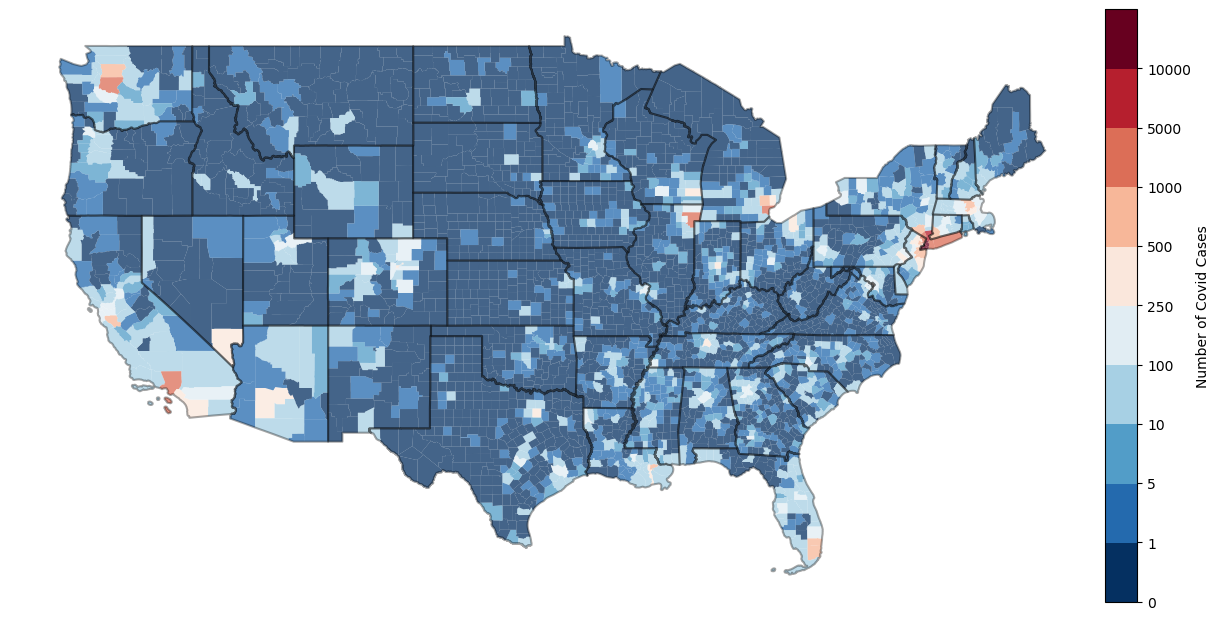

In [261]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize = (12,8))

plt.tight_layout()
plt.rcParams.update(plt.rcParamsDefault) # This will reset defaluts...

#################################################################################
# This is for the colorbar...

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=0.1)

#################################################################################
## This creates a discrete colorbar scheme...
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a

N = 10

base = plt.cm.get_cmap("RdBu_r")

color_list = base(np.linspace(0, 1, N))

cmap_name = base.name + str(N)

dcmap =  base.from_list(cmap_name, color_list, N)

#################################################################################
# This is the normal mapping...

#us_map[us_map.q_cases.isna()].plot(alpha = 0.25, color = "grey", ax = ax,)

us_map.plot(column='q_cases', ax = ax,
              # THIS IS NEW, it says color it based on this column
             cmap=dcmap, 
             alpha = 0.75,
             vmin=0, vmax=us_map.q_cases.max())

#################################################################################
# This then alows me to generate and edit the colorbar....
# https://stackoverflow.com/questions/53158096/editing-colorbar-legend-in-geopandas

sm = plt.cm.ScalarMappable(cmap=dcmap)
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

cbr.set_label('Number of Covid Cases')
cbr.set_alpha(0.15)

cbr.set_ticks([0, 0.10, 0.20, 0.30,0.40,0.50,0.60,0.70,0.80, 0.90])
cbr.set_ticklabels(q_cases, update_ticks=True)

#################################################################################

state_map.geometry.boundary.plot(color=None, edgecolor='k', alpha = 0.35, ax = ax)

#################################################################################
# Then some final stuff to clean things up....

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.get_xaxis().set_visible(False)

ax.get_yaxis().set_visible(False)

title = "Covid-19 Cases by County as of " + latest_date + ", Total Cases: " + str(total).map('{:,.0f}'.format)
ax.set_title(title, fontsize = 16, loc= "left" )

plt.savefig("covid-19-map.png", bbox_inches = "tight", dip = 1200)

plt.show()

In [258]:
import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.models import Title

from bokeh.plotting import figure, save

from bokeh.resources import CDN
from bokeh.embed import file_html

# Input GeoJSON source that contains features for plotting
#geosource = GeoJSONDataSource(geojson = us_map.to_json())

In [259]:
state_geosource = GeoJSONDataSource(geojson = state_map.to_json())

geosource = GeoJSONDataSource(geojson = us_map.to_json())

palette = brewer['RdBu'][10]

#https://docs.bokeh.org/en/latest/docs/reference/palettes.html

color_mapper = LinearColorMapper(palette = palette, low = 0, high = 9)

tick_labels = {2:str(q_cases[2]), 
              4:str(q_cases[4]), 6:str(q_cases[6]), 8 :str(q_cases[9])}

color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 20, height = 420,
                     border_line_color = None,
                     orientation = "vertical",
                     location=(0,0), major_label_overrides = tick_labels,
                     major_tick_line_alpha = .25)

label = 'Percentile in Distribution of Covid Cases'
# Create figure object.
p = figure( 
           plot_height = 600 ,
           plot_width = 950, 
           toolbar_location = 'below',
           tools = "box_zoom, reset")

descip = "Colorbar reports # of cases; Hover tool reports county name, # of covid-19 cases."
descip = descip + "Data from https://github.com/nytimes/covid-19-data"
p.add_layout(Title(text=descip, text_font_style="italic", text_font_size="9pt"), 'above')
p.add_layout(Title(text=title, text_font_size="11pt"), 'above')

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.

states = p.patches('xs','ys', source = geosource,
                   fill_color = {"field" :'q_cases',
                                 "transform" : color_mapper},
                   line_color = "gray", 
                   line_width = 0.25, 
                   fill_alpha = 1)

state_line = p.multi_line('xs','ys', source = state_geosource,
                   line_color = "black", 
                   line_width = 0.5)
# Create hover tool

p.add_tools(HoverTool(renderers = [states],
                      tooltips = [('County','@NAME'),
                                ('Cases','@cases_label'),
                                 ('Deaths','@deaths_label'),
                                 ('Data Notes','@Notes')]))

#### Some features to make it a bit nicer. 

p.axis.visible = False
p.background_fill_color = "grey"
p.background_fill_alpha = 0.25

p.toolbar.autohide = True

p.add_layout(color_bar, "right")

## Send to doc file, create a webpage from doc file on github
# then had weebly webiste point to that .html file. That's how
# I got this to work.

file_path = os.getcwd()

doc_path = file_path +"\\docs"

outfp = doc_path + "\\us_covid_map.html"

# Save the map
save(p, outfp)

# Not sure if this is important, but seemed to start working once
# I ran it
html = file_html(p, CDN, outfp)

C:\ProgramData\Anaconda3\lib\site-packages\bokeh\io\saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
C:\ProgramData\Anaconda3\lib\site-packages\bokeh\io\saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")
